In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import time

import statsmodels.api as sm

import base64
import io
from PIL import Image
from IPython.display import display

import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))

from utils import experiment_to_prompt
from utils import round_to_significant_figures
from img_utils import hash_image, decode_base64_and_plot

from sklearn import datasets

from openai import OpenAI
import anthropic
import json
import pickle

from tqdm import tqdm

## Data generation functions

In [2]:
def generate_random_noisy_line(seed, 
                               num_points=50, 
                               base_noise_scale=0.1, 
                               box_size=10):

    np.random.seed(seed)

    def random_point_on_box(side, box_size=10):
        if side == 'left':
            x = 0
            y = np.random.uniform(0, box_size)
        elif side == 'right':
            x = box_size
            y = np.random.uniform(0, box_size)
        else:
            raise ValueError(f"Invalid side: {side}")
        return np.array([x, y])

    # Choose two random endpoints inside the box
    p0 = random_point_on_box('left', box_size)
    p1 = random_point_on_box('right',box_size)
    
    # Create a straight line between p0 and p1
    t = np.linspace(0, 1, num_points)
    line = np.outer(1 - t, p0) + np.outer(t, p1)

    # Compute slope
    dx = p1[0] - p0[0]
    dy = p1[1] - p0[1]

    slope = dy / dx

    slope_factor = np.arctan(np.abs(slope)) / (np.pi / 2)  # Normalize between 0 and 1
    noise_scale = base_noise_scale * slope_factor
    
    # Add noise
    noise = np.random.normal(scale=noise_scale, size=line.shape)
    noisy_line = line + noise
    
    # Clip to stay within bounds if needed
    noisy_line = np.clip(noisy_line, 0, box_size)

    # # pick a random point in the line
    # random_index = np.random.randint(0, num_points)

    # # calculate the range of the y-values
    # y_range = np.max(noisy_line[:, 1]) - np.min(noisy_line[:, 1])

    # sign = np.random.choice([-1, 1])
    # noisy_line[random_index, 1] += sign * range_coeff * y_range

    return noisy_line

def get_jackknife_residuals(x, y):
    """
    Compute jackknife (leave-one-out) residuals for linear regression of y on x.

    Parameters
    ----------
    x : array_like, shape (n,)
        Predictor values.
    y : array_like, shape (n,)
        Response values.

    Returns
    -------
    r_loo : ndarray, shape (n,)
        The jackknife residuals, i.e. e_i / (1 - h_ii), where
        e_i = y_i - ŷ_i is the ordinary residual and h_ii is the leverage.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError("x and y must both be one-dimensional arrays")
    if x.size != y.size:
        raise ValueError("x and y must have the same length")

    n = x.size
    # Design matrix with intercept
    X = np.column_stack((np.ones(n), x))

    # Compute (X'X)^{-1} X'y  and hat-matrix diagonal
    XtX_inv = np.linalg.inv(X.T @ X)
    beta = XtX_inv @ (X.T @ y)
    hat_diag = np.einsum('ij,ji->i', X, XtX_inv @ X.T)  # h_ii

    # Fitted values and ordinary residuals
    y_hat = X @ beta
    resid = y - y_hat

    # Jackknife (leave-one-out) residuals
    r_loo = resid / (1.0 - hat_diag)

    return r_loo

import numpy as np

def get_outlier_line(line, seed, threshold=3.0, step_size=0.25, max_iter=10000):
    # 1) generate your base line+noise:

    output = line.copy()
    np.random.seed(seed)

    # 2) pick one random point to turn into an outlier
    idx = np.random.randint(0, output.shape[0])

    # 3) compute its jackknife residual
    resid = get_jackknife_residuals(output[:,0], output[:,1])[idx]

    i = 0
    while abs(resid) < threshold and i < max_iter:
        i += 1
        # move in the *same* direction as the residual: 
        #   if resid > 0, push upward; if resid < 0, push downward
        direction = np.sign(resid)
        if direction == 0:
            # if it happens to be exactly zero, pick a random direction
            direction = np.random.choice([-1, 1])

        output[idx, 1] += step_size * direction

        # recompute the jackknife residual for that point
        resid = get_jackknife_residuals(output[:,0], output[:,1])[idx]

    if abs(resid) < threshold:
        raise RuntimeError(f"Failed to exceed |resid|={threshold} after {max_iter} steps")
    return output, idx

## Eval utilities

In [3]:
def get_resids(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit() 
    influence = model.get_influence()
    standardized_residuals = influence.resid_studentized_internal
    return standardized_residuals

# calculate z score in y direction
def get_z_score(df, idx):
    outlier_x = df['x'][idx]
    outlier_y = df['y'][idx]

    z_score_x = (outlier_x - df['x'].mean()) / df['x'].std()
    z_score_y = (outlier_y - df['y'].mean()) / df['y'].std()
    return z_score_x, z_score_y

## Hashing

In [4]:
def hash_image(df):
    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])

    # Save the figure to an in-memory bytes buffer in PNG format
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)  # Close the figure to free resources
    buf.seek(0)     # Rewind the buffer to the beginning

    # Convert the image in the buffer to a base64 encoded string
    img_bytes = buf.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64

def unhash_image(img_base64):

    # decode pic_hash to png
    # Step 1: Decode the base64 hash back to bytes
    pic_bytes = base64.b64decode(img_base64)

    # Step 2: Convert bytes to an image using PIL
    image = Image.open(io.BytesIO(pic_bytes))
    return image


## Data generation procedure

In [24]:
seed = 0

output = generate_random_noisy_line(seed=seed, 
                                    num_points=20, 
                                    base_noise_scale=0.3, 
                                    box_size=10)

new_line_less_noise, idx = get_outlier_line(output,
                                    seed=seed, 
                                    threshold=1.5, 
                                    step_size=0.1, 
                                    max_iter=10000)

new_line, idx = get_outlier_line(output,
                                    seed=seed, 
                                    threshold=2.5, 
                                    step_size=0.1, 
                                    max_iter=10000)

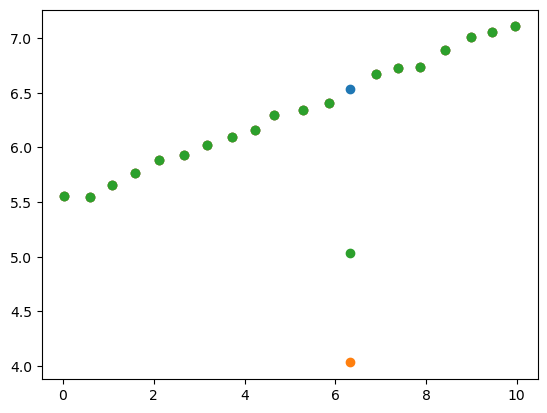

In [25]:
plt.scatter(output[:, 0], output[:, 1])
plt.scatter(new_line[:, 0], new_line[:, 1])
plt.scatter(new_line_less_noise[:, 0], new_line_less_noise[:, 1])
plt.scatter
plt.show()

In [5]:
final_df = pd.DataFrame(columns=['x', 'y', 'img_b64', 'z_score_y', 'z_score_x', 'scale', 'outlier', 'outlier_idx', 'original_index', 'type'])

In [6]:
for scale in [1, 100, 10000]:
    for type in ['true', 'misleading']:
        for seed in range(100):

            np.random.seed(seed)

            output = generate_random_noisy_line(seed=seed, 
                                                num_points=20, 
                                                base_noise_scale=0.3, 
                                                box_size=10)
            
            new_line, idx = get_outlier_line(output,
                                                seed=seed, 
                                                threshold=2.5, 
                                                step_size=0.1, 
                                                max_iter=10000)
            
            misleading_df = pd.DataFrame(output, columns=['x', 'y'])
            df = pd.DataFrame(new_line, columns=['x', 'y'])

            for el in [df, misleading_df]:
                el['x'] = el['x'] * scale
                el['y'] = el['y'] * scale

                el['x'] = round_to_significant_figures(el['x'], 4)
                el['y'] = round_to_significant_figures(el['y'], 4)

            outlier = (df['x'][idx], df['y'][idx])
            z_score_x, z_score_y = get_z_score(df, idx)

            img_b64 = hash_image(df) if type == 'true' else hash_image(misleading_df)

            df = df.sample(frac=1).reset_index()
            to_add = {
                'x': [df['x'].tolist()],
                'y': [df['y'].tolist()],
                'img_b64': img_b64,
                'z_score_y': z_score_y,
                'z_score_x': z_score_x,
                'scale': scale,
                'outlier' : [outlier],
                'outlier_idx': idx,
                'original_index': [df['index'].tolist()],
                'type': type
            }
            final_df = pd.concat([final_df, pd.DataFrame(to_add)])

/var/folders/g_/cwvjv87n3wq590ldrjtpds000000gn/T/ipykernel_35355/2963086403.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, pd.DataFrame(to_add)])


KeyboardInterrupt: 

In [62]:
# save to csv
final_df.to_csv('input_dataframe.csv', index=True)

In [94]:
def decode_base64_and_plot(base64_str, name=None, save=True):
    # # Decode the base64 string
    # img_data = base64.b64decode(base64_str)

    # # Create a BytesIO object from the decoded data
    # img_buffer = io.BytesIO(img_data)

    # # Read the image from the buffer and display it
    # img = plt.imread(img_buffer)
    # plt.imshow(img)
    # plt.axis('off')  # Hide axes
    # plt.show()
    # if save: 
    #     # plt.tight_layout()
    #     # Save the image to a file
    #     fig.savefig('images/cluster_ex.pdf', dpi=300, bbox_inches='tight')

    # Decode the base64 string
    img_data = base64.b64decode(base64_str)

    # Create a BytesIO object from the decoded data
    img_buffer = io.BytesIO(img_data)

    # Read the image from the buffer
    img = plt.imread(img_buffer)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')  # Hide axes

    if save:
        # Save the image to a file, create the file if it doesn't exist
        if not os.path.exists('images'):
            os.makedirs('images')
        fig.savefig(f'images/{name}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

In [87]:
from img_utils import decode_base64_and_plot

In [88]:
# set dpi to 300 through rcparams
plt.rcParams['figure.dpi'] = 300

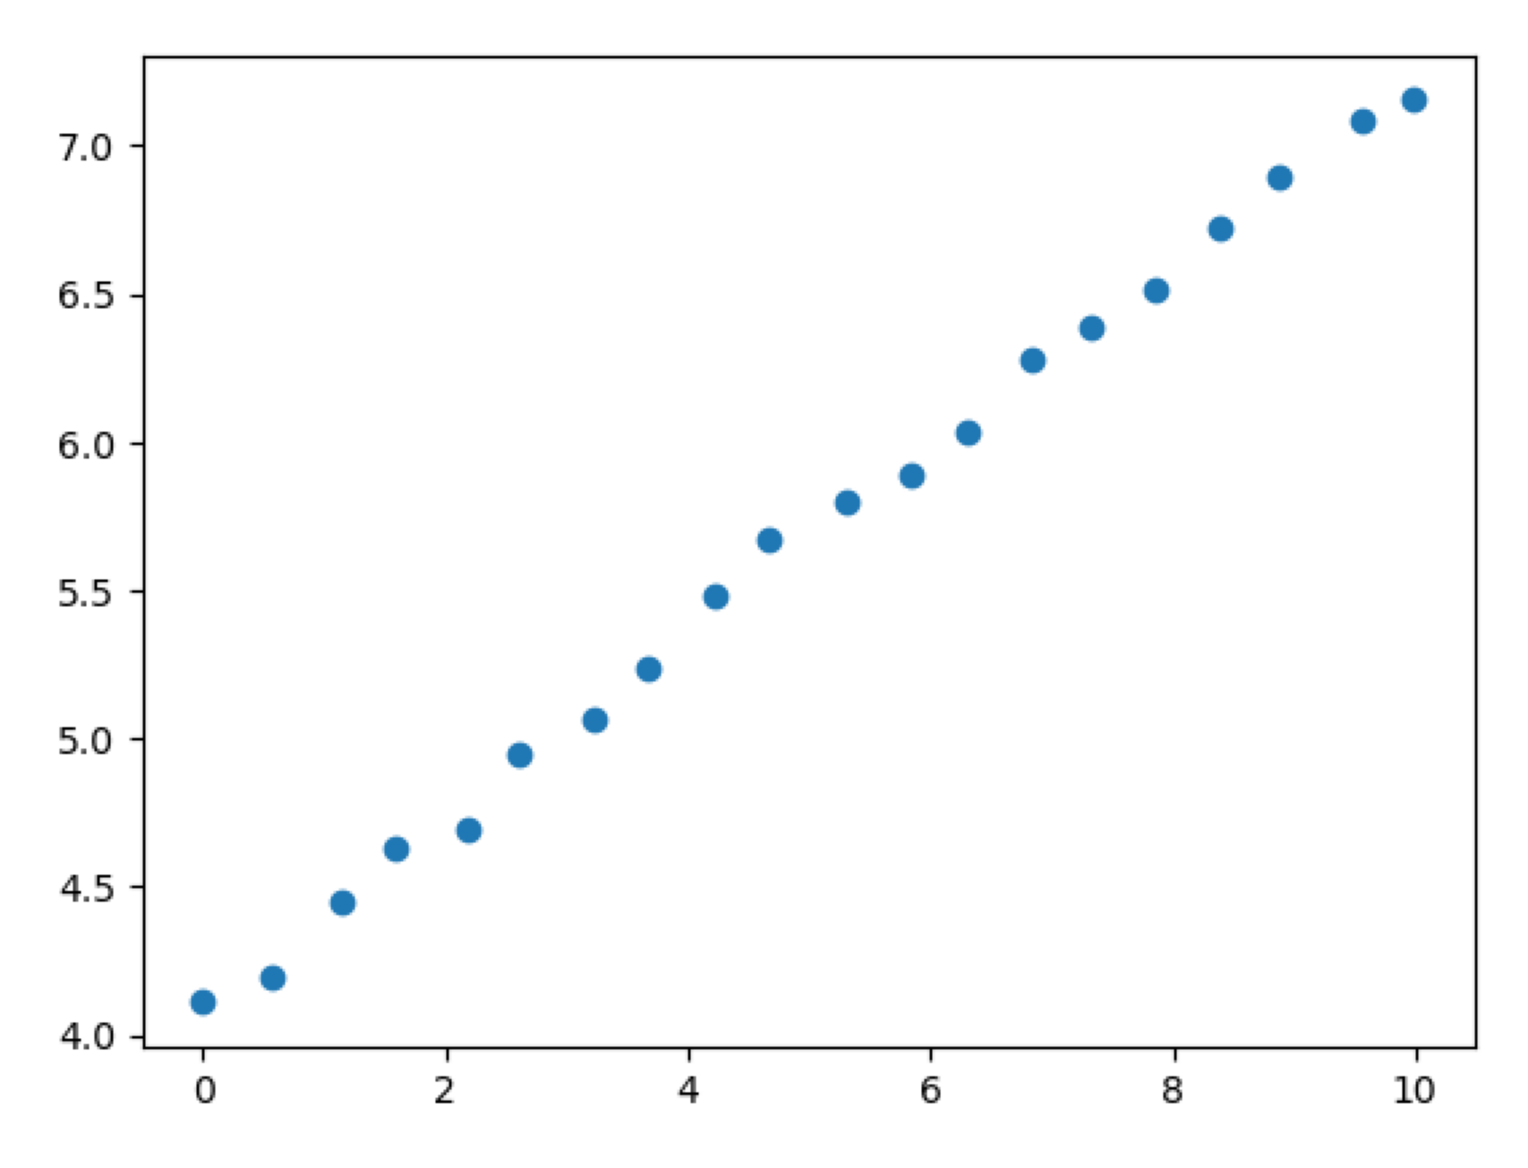

In [96]:
 decode_base64_and_plot(final_df.iloc[101]['img_b64'], name='deceptive_outlier_plot', save=True)

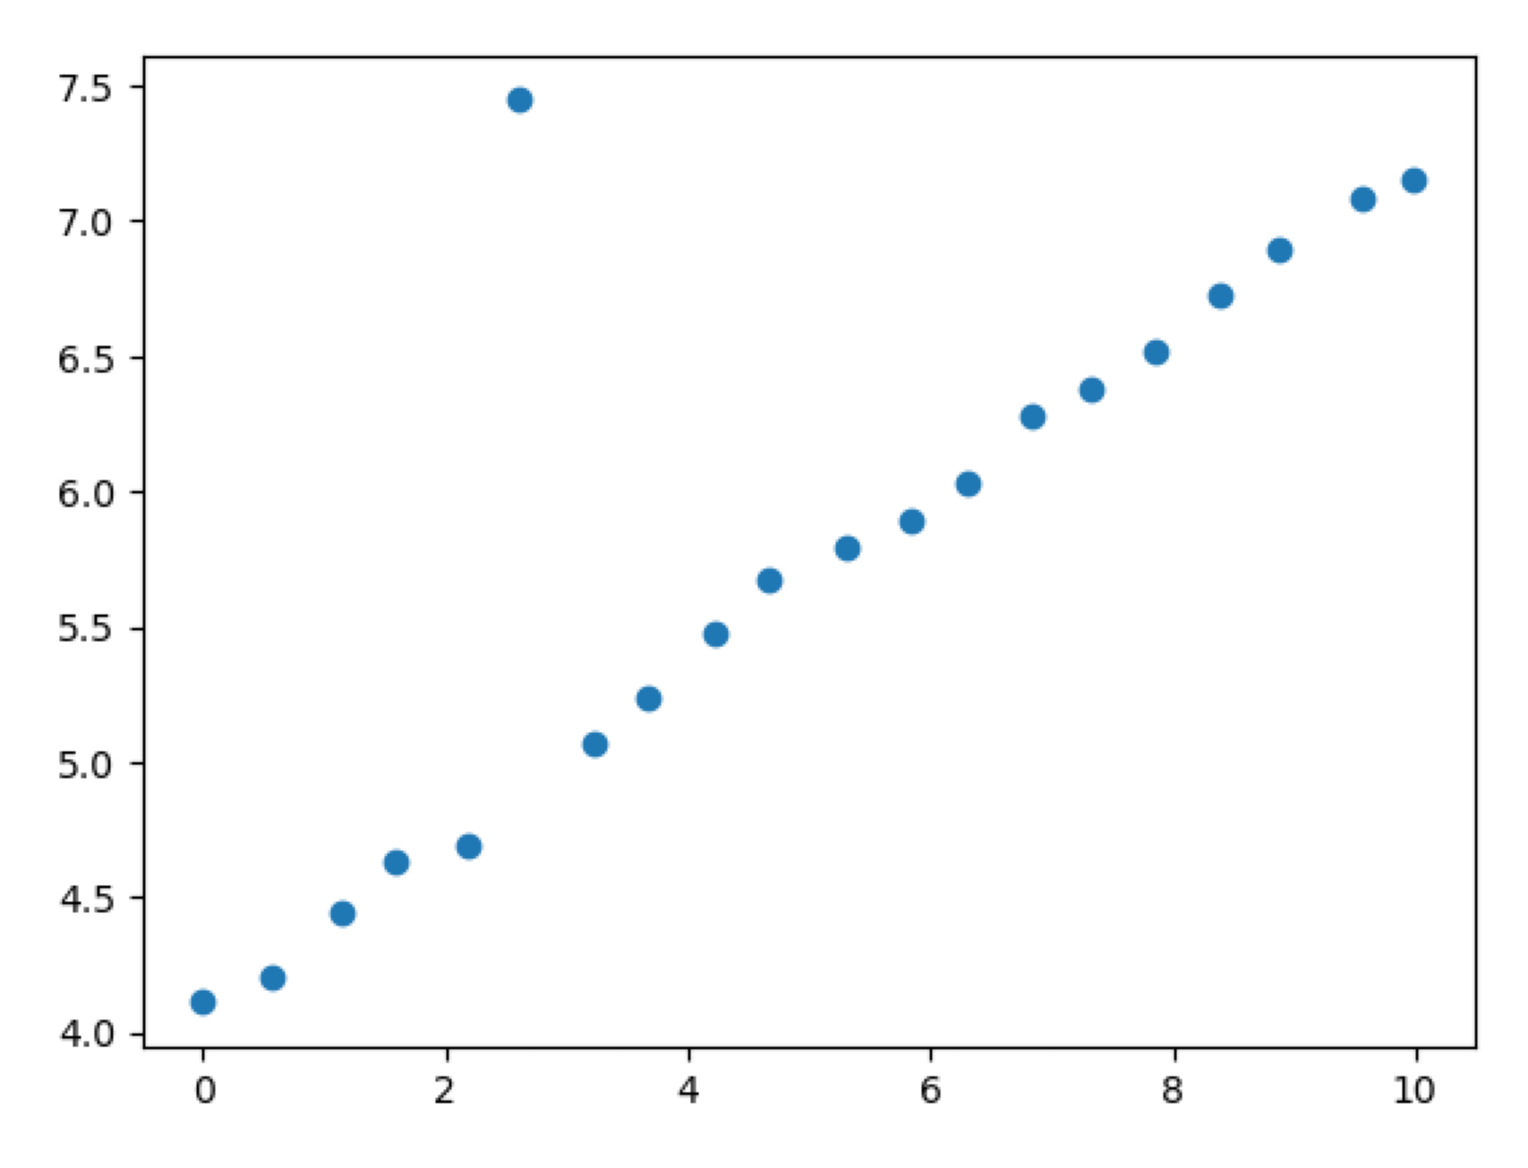

In [97]:
decode_base64_and_plot(final_df.iloc[1]['img_b64'], name='outlier_plot', save=True)

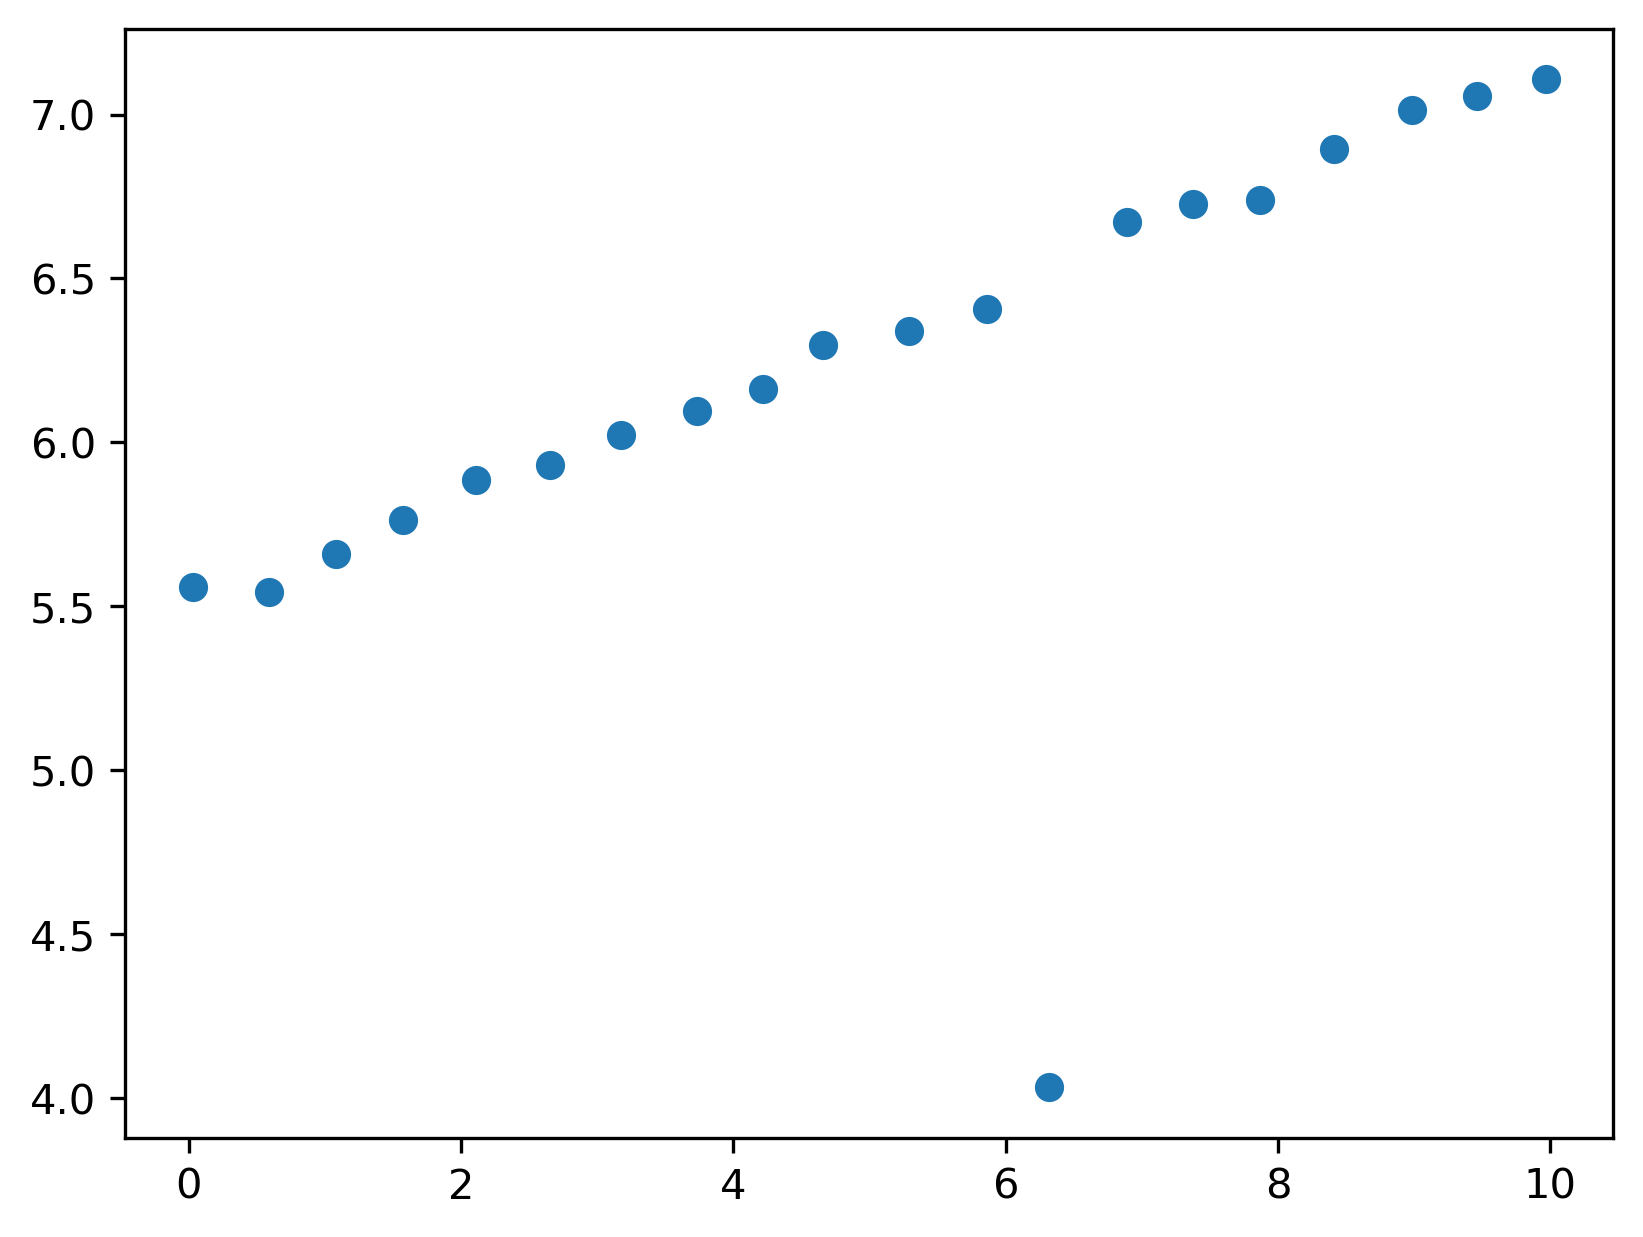

In [85]:
plt.scatter(final_df.iloc[0]['x'], final_df.iloc[0]['y'])

In [78]:
final_df.iloc[0]['img_b64']

'iVBORw0KGgoAAAANSUhEUgAAAiMAAAGdCAYAAADAAnMpAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAl2klEQVR4nO3de3BU9f3/8deSYIJMskpKspufAQJDC0lUIBG5iNYviAiT+XZKcbRQqYxMoViEDC1GnYF4IdWik6FYMmEoU8x4+SNqSbkIthJqjQ3XVuQirRmDMWmGYndRJxtJzu8Pmv26JAvZsLuf3bPPx8z5Yz/7OXve2VH2Ned8Lg7LsiwBAAAYMsB0AQAAILERRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYlWy6gL7o6urSZ599prS0NDkcDtPlAACAPrAsS+fPn1d2drYGDAh+/yMuwshnn32mnJwc02UAAIB+OHPmjG644Yag78dFGElLS5N08Y9JT083XA0AAOgLr9ernJwc/+94MHERRrofzaSnpxNGAACIM1caYsEAVgAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRcbHoGQAACL/OLksNjefUdr5dmWmpmpg7REkDor8HHGEEAIAEtPtYi8pqj6vF0+5vcztTtaY4T7MK3FGthcc0AAAkmN3HWrS0+nBAEJGkVk+7llYf1u5jLVGthzACAEAC6eyyVFZ7XFYv73W3ldUeV2dXbz0igzACAEACaWg81+OOyDdZklo87WpoPBe1mggjAAAkkLbzwYNIf/qFAwNYAQCIYeGe8ZKZlhrWfuFAGAEAIEZFYsbLxNwhcjtT1epp73XciEOSy3kx9EQLj2kAAIhBkZrxkjTAoTXFeZIuBo9v6n69pjgvquuNEEYAAIgxkZ7xMqvArU0LJsjlDHwU43KmatOCCVFfZ4THNAAAxJhQZrx

In [79]:
final_df.iloc[100]['img_b64']

'iVBORw0KGgoAAAANSUhEUgAAAiMAAAGdCAYAAADAAnMpAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAtLUlEQVR4nO3dcXRUdX7//9ckgRnYTYaT1DCDxjAirsRYAWO6EKm7XUGUk56eVViVCIp6hMWNQrEa7TFE3bDQ4qEu3XhClZaDUquCklaiWCuIQoNBrSEU1KQGwoQcDDsTcROX5P7+4Jf5OiYDmWRm7syd5+Oc+eN+5nNn3pmzy335+dz7+dgMwzAEAABgkhSzCwAAAMmNMAIAAExFGAEAAKYijAAAAFMRRgAAgKkIIwAAwFSEEQAAYCrCCAAAMFWa2QUMRm9vr44fP6709HTZbDazywEAAINgGIY6Ozs1btw4paSEHv9IiDBy/Phx5eTkmF0GAAAYgqNHj+qiiy4K+X5ChJH09HRJZ/+YjIwMk6sBAACD4ff7lZOTE7iOh5IQYaRvaiYjI4MwAgBAgjnfLRbcwAoAAExFGAEAAKYijAAAAFMRRgAAgKkIIwAAwFSEEQAAYCrCCAAAMBVhBAAAmCohFj0DAACR19NrqK65Q+2dXcpOd6jQk6nUlNjvAUcYAQAgCdU2eFVR0yivryvQ5nY6VF6cp9n57pjWwjQNAABJprbBqyWbDwQFEUlq83VpyeYDqm3wxrQewggAAEmkp9dQRU2jjAHe62urqGlUT+9APaKDMAIAQBKpa+7oNyLyXYYkr69Ldc0dMauJMAIAQBJp7wwdRIbSLxIIIwAAJJHsdEdE+0UCYQQAgCRS6MmU2+lQqAd4bTr7VE2hJzNmNRFGAABIIqkpNpUX50lSv0DSd1xenBfT9UYIIwAAJJnZ+W5VlUyVyxk8FeNyOlRVMjXm64yw6BkAAElodr5bM/NcrMAKAADMk5pi07QJWWa

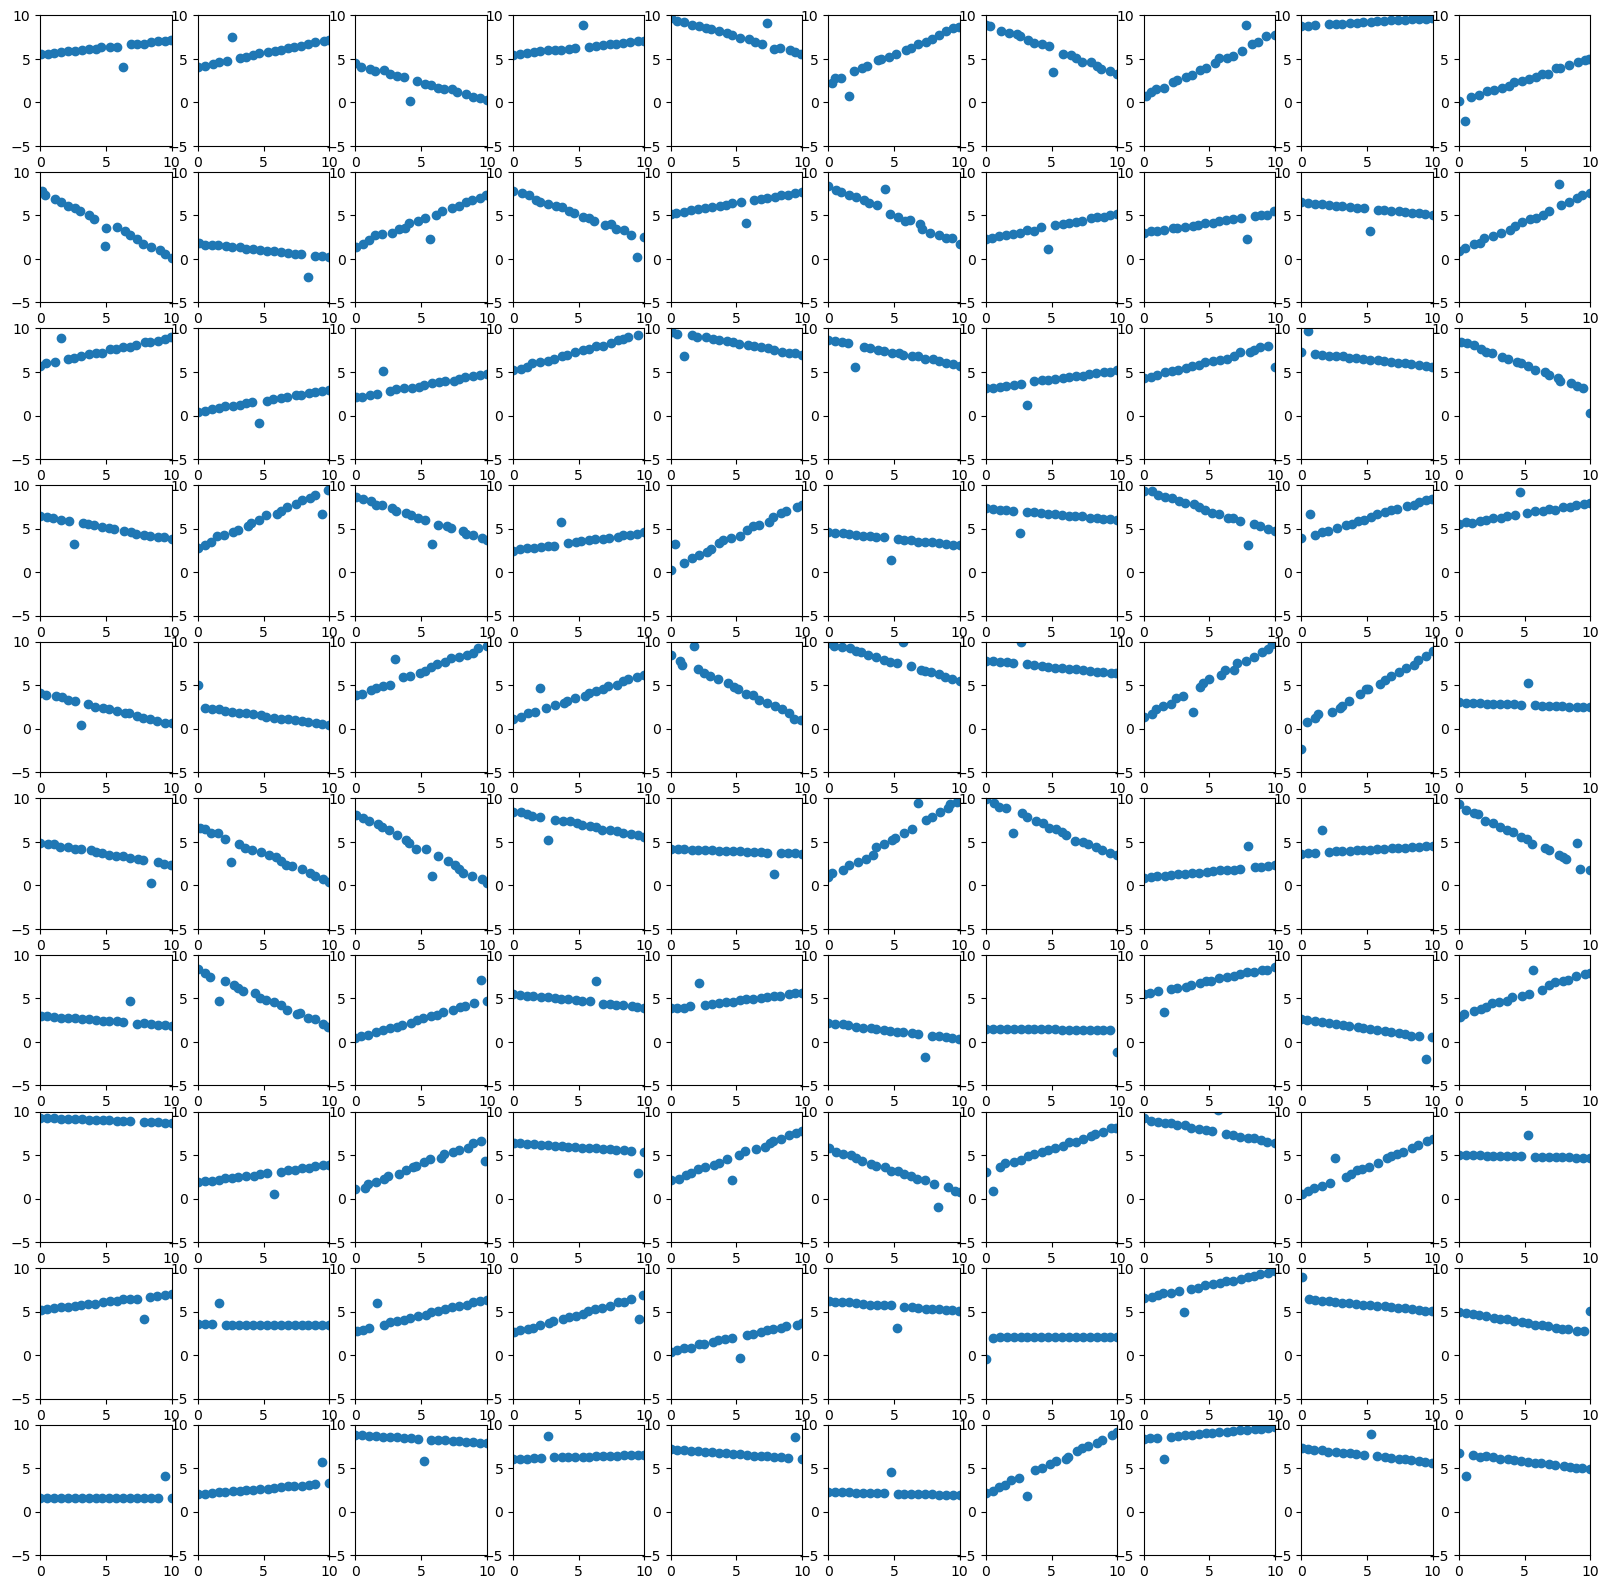

In [8]:
# generate 10x10 grid of plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i, j].scatter(df_lst[i * 10 + j]['x'], df_lst[i * 10 + j]['y'])
        # set x and y limits to 0-10
        axes[i, j].set_xlim(0, 10)
        axes[i, j].set_ylim(-5, 10)
plt.show()